Data merged



C:\Users\Dennis\AppData\Local\Temp\ipykernel_25244\2393479220.py:73: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_data = filtered_data.groupby('Genmodel_ID').apply(sample_images).reset_index(drop=True)


Data filtered

Data split

Model compiled

Epoch 1/20
25/25 [==============================] - 33s 81ms/step - loss: 1.0598 - mae: 0.6931 - val_loss: 1.0075 - val_mae: 0.7007
Epoch 2/20
25/25 [==============================] - 1s 26ms/step - loss: 0.9829 - mae: 0.6927 - val_loss: 1.0049 - val_mae: 0.7332
Epoch 3/20
25/25 [==============================] - 1s 22ms/step - loss: 0.9747 - mae: 0.6853 - val_loss: 0.9888 - val_mae: 0.7221
Epoch 4/20
25/25 [==============================] - 1s 23ms/step - loss: 0.9624 - mae: 0.6924 - val_loss: 0.9790 - val_mae: 0.6846
Epoch 5/20
25/25 [==============================] - 1s 22ms/step - loss: 0.9396 - mae: 0.6842 - val_loss: 0.9821 - val_mae: 0.6449
Epoch 6/20
25/25 [==============================] - 1s 23ms/step - loss: 0.9290 - mae: 0.6669 - val_loss: 0.9829 - val_mae: 0.6239
Epoch 7/20
25/25 [==============================] - 1s 21ms/step - loss: 0.9588 - mae: 0.6455 - val_loss: 0.9814 - val_mae: 0.6335
Epoch 8/20
25/25 [=====================

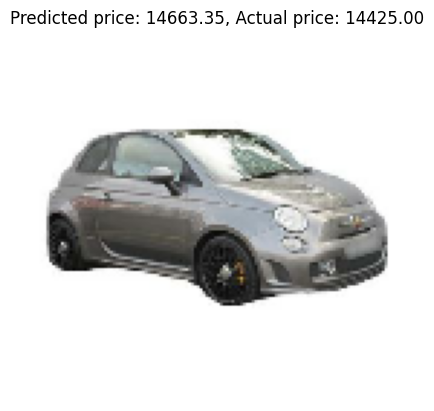

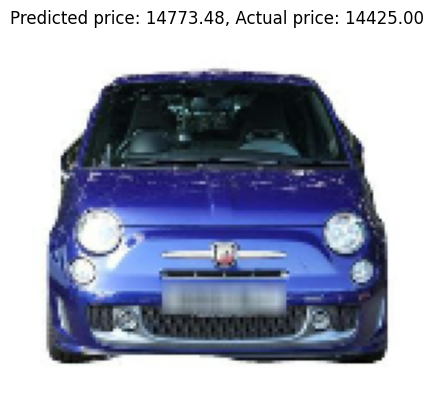

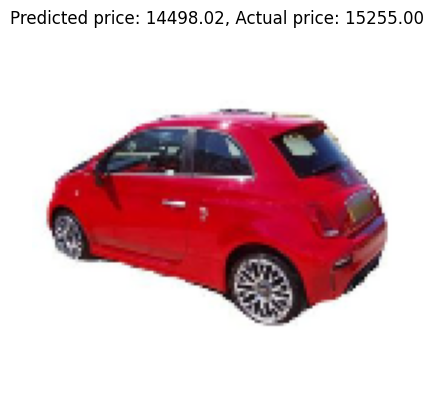

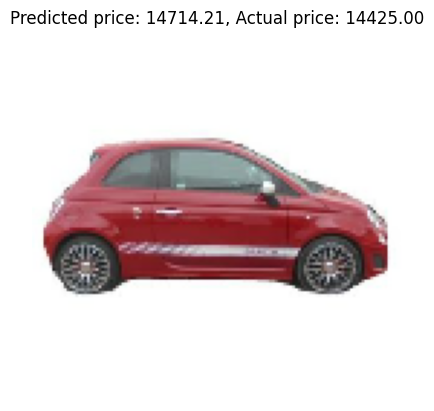

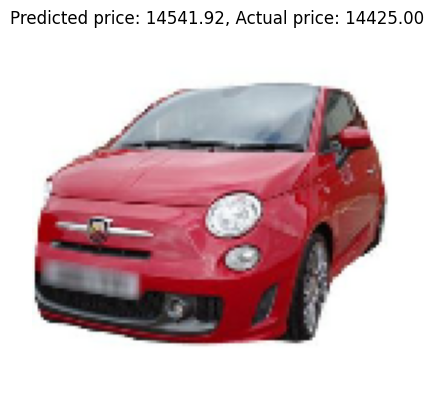

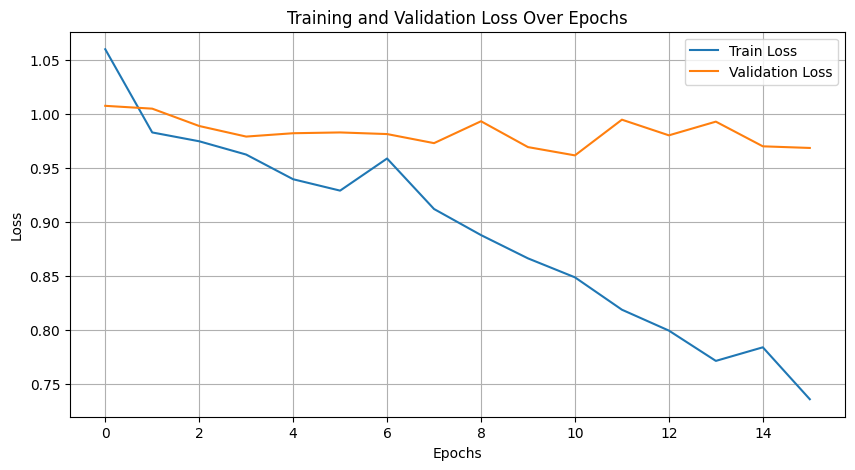

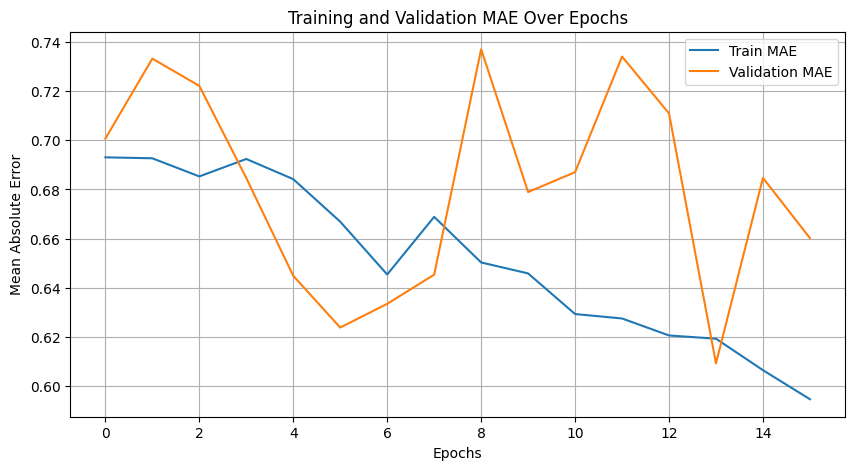

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense,
                                     Dropout, BatchNormalization, InputLayer)
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score  # Import r2_score
from pathlib import Path  # Import Path for checking file existence
from tensorflow.keras.regularizers import l2

# Paths to your CSV files
image_table = pd.read_csv('D:\\CPEN355_project\\Data\\Image_table.csv')
price_table = pd.read_csv('D:\\CPEN355_project\\Data\\Price_table.csv')

# Read Image_table.csv into a DataFrame
df_images = image_table

# Function to extract Year from Image_name
def extract_year(image_name):
    # Split the Image_name by '$$'
    parts = image_name.split('$$')
    if len(parts) > 2:
        year = parts[2].strip()
        return year
    else:
        return None

# Apply the function to create a new 'Year' column in df_images
df_images['Year'] = df_images['Image_name'].apply(extract_year)

# Read Price_table.csv into a DataFrame
df_prices = price_table

# Convert the 'Year' columns to strings to ensure consistent data types
df_images['Year'] = df_images['Year'].astype(str)
df_prices['Year'] = df_prices['Year'].astype(str)

# Merge the DataFrames on 'Genmodel_ID' and 'Year'
df_merged = pd.merge(df_images, df_prices, on=['Genmodel_ID', 'Year'], how='left')

df_merged = df_merged.dropna(subset=['Entry_price'])

# Ensure 'Entry_price' is of numeric type
df_merged['Entry_price'] = df_merged['Entry_price'].astype(float)


print("Data merged\n")


#/////////////////////////Start filtering out dataset////////////////////////////////

# Count the number of images per Genmodel_ID
image_counts = df_merged['Genmodel_ID'].value_counts()

# Remove Genmodel_IDs with fewer than 300 images
valid_genmodels = image_counts[image_counts >= 300].index

# Filter merged_data to only include valid Genmodel_IDs
filtered_data = df_merged[df_merged['Genmodel_ID'].isin(valid_genmodels)]

# For Genmodel_IDs with counts > 500, randomly select 500 images
def sample_images(group):
    if len(group) > 1000:
        return group.sample(n=1000, random_state=42)
    else:
        return group

filtered_data = filtered_data.groupby('Genmodel_ID').apply(sample_images).reset_index(drop=True)

print("Data filtered\n")

#/////////////////////////End filtering out dataset////////////////////////////////


# Add full image paths to filtered_data
image_directory = 'D:\\CPEN355_project\\Data\\DVM_noNest_test'  # Update with your image directory
filtered_data['Image_path'] = filtered_data['Image_name'].apply(
    lambda x: f"{image_directory}\\{x}"
)

# Check if images exist and filter out non-existent images
def image_exists(path):
    return Path(path).is_file()

exists_mask = filtered_data['Image_path'].apply(image_exists)
filtered_data = filtered_data[exists_mask].reset_index(drop=True)

# Now define image_paths and prices
image_paths = filtered_data['Image_path']
prices = filtered_data['Entry_price'].values

# Prepare image data and prices
img_size = 128  # Resize images to 128*128
batch_size = 32

scaler = StandardScaler()
prices_scaled = scaler.fit_transform(prices.reshape(-1, 1))

X_train_paths, X_test_paths, y_train_scaled, y_test_scaled = train_test_split(
    image_paths, prices_scaled, test_size=0.2, random_state=42)

print("Data split\n")

def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [img_size, img_size])
    image = image / 255.0
    return image, label

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_paths.values, y_train_scaled))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_paths.values, y_test_scaled))

train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


model = Sequential([
    Conv2D(16, (3, 3), activation='linear', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(2, 2),

    Conv2D(32, (3, 3), activation='tanh'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='leaky_relu'),
    MaxPooling2D(3, 3),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)  # Single output for regression
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mae'])

print("Model compiled\n")

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_cnn_model3.h5', monitor='val_loss', save_best_only=False)

history = model.fit(train_dataset, epochs=20,
                    validation_data=test_dataset,
                    callbacks=[early_stopping, model_checkpoint])

print("Finished training\n")

loss, mae = model.evaluate(test_dataset)

print(f"Standardized MAE: {mae}")

predictions_scaled = model.predict(test_dataset)
predictions_scaled = np.concatenate(predictions_scaled, axis=0)
y_test_scaled_flat = np.concatenate([y for x, y in test_dataset], axis=0)

predictions = scaler.inverse_transform(predictions_scaled.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test_scaled_flat.reshape(-1, 1))

mae_original = mean_absolute_error(y_test, predictions)
print(f"Original MAE: {mae_original}")
print("Test sample number:", len(y_test))

# Compute R² score
r2 = r2_score(y_test, predictions)
print(f"R² score: {r2}")

import matplotlib.pyplot as plt

test_images = []
test_labels = []
for image, label in test_dataset.unbatch().take(5):
    test_images.append(image.numpy())
    test_labels.append(label.numpy())

test_predictions = model.predict(np.array(test_images))
test_predictions = scaler.inverse_transform(test_predictions)

for i in range(len(test_images)):
    plt.imshow(test_images[i])
    plt.axis('off')

    actual_price = scaler.inverse_transform(test_labels[i].reshape(-1, 1))[0][0]
    predicted_price = test_predictions[i][0]
    plt.title(f"Predicted price: {predicted_price:.2f}, Actual price: {actual_price:.2f}")

    plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation MAE
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)
plt.show()